## Import Libraries

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import img_to_array
#path = 'C:/Users/ANKUR/Downloads/Dataset_BUSI_with_GT/'
#path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Original_dataset/' 

In [ ]:
def number_of_images(img) :
    value = 0
    for i in range(len(img)) :
        if img[i] == '(' :
            while True :
                i += 1
                if img[i] == ')' :
                    break
                value = (value*10) + int(img[i])
            break
    
    return value

In [ ]:
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m = np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [ ]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[number_of_images(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[number_of_images(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[number_of_images(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[number_of_images(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[number_of_images(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[number_of_images(image)-1]+= img_to_array(pil_img)

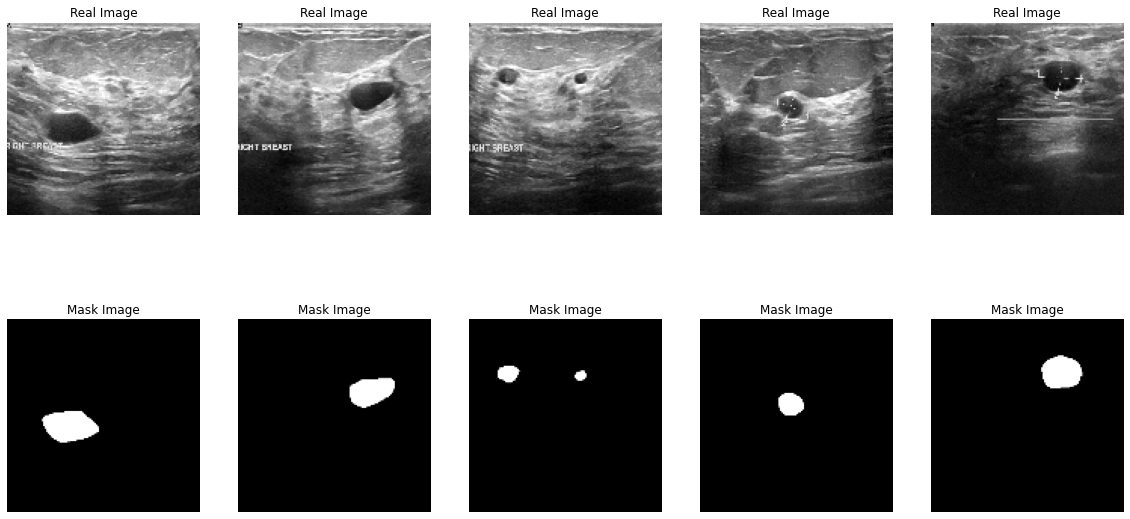

In [ ]:
plt.figure(figsize = (20,10))

for i in range(5) :
    plt.subplot(2,5,i+1)
    plt.imshow(X_b[i+1].reshape(128,128), 'gray')
    plt.title('Real Image')
    plt.axis('off')

for i in range(5) :
    plt.subplot(2,5,i+6)
    plt.imshow(y_b[i+1].reshape(128,128), 'gray')
    plt.title('Mask Image')
    plt.axis('off')
plt.show()

In [ ]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)
X /= 255.0
y /= 255.0
print(X.shape)
print(y.shape)
print(X.max())
print(X.min())
print(y.max())
print(y.min())

(780, 128, 128, 1)
(780, 128, 128, 1)
1.0
0.0
2.0
0.0


In [ ]:
y[y > 1.0] = 1.0
print(y.max())
print(y.min())

1.0
0.0


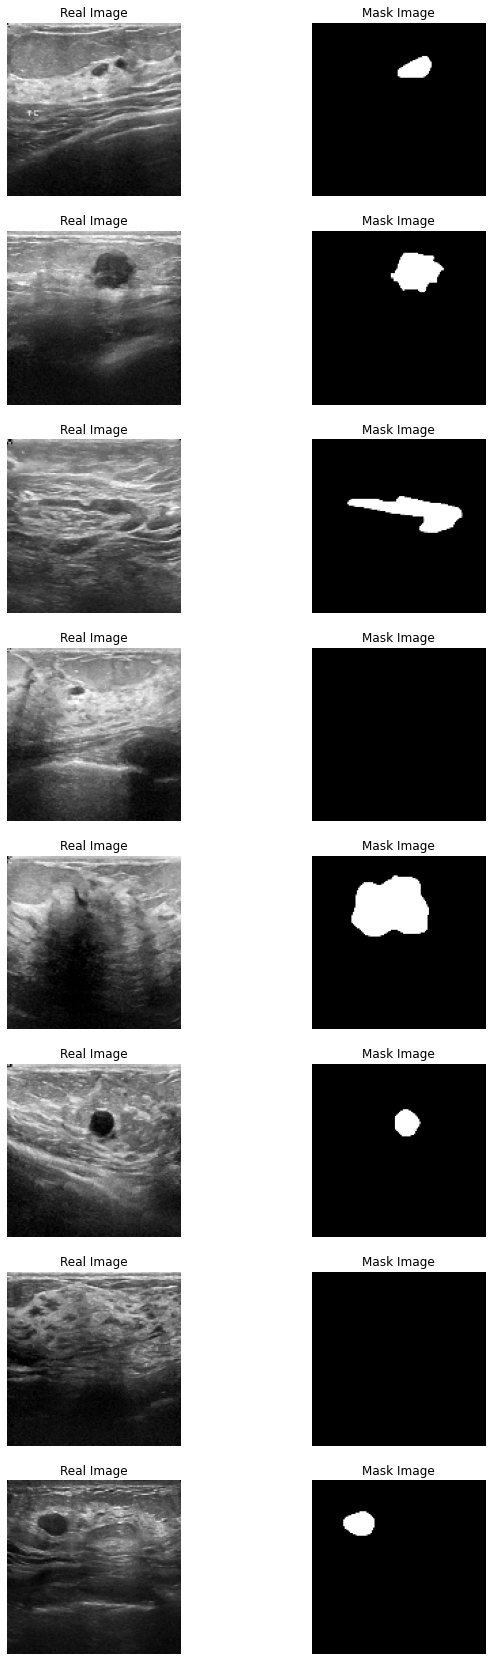

In [ ]:
plt.figure(figsize = (10,30))
i = 0
while i < 16 :
    
    x = np.random.randint(0,780)
    
    plt.subplot(8,2,i+1)
    plt.imshow(X[x].reshape(128,128),'gray')
    plt.title('Real Image')
    plt.axis('off')
    
    plt.subplot(8,2,i+2)
    plt.imshow(y[x].reshape(128,128),'gray')
    plt.title('Mask Image')
    plt.axis('off')
    
    i += 2
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 1)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(741, 128, 128, 1)
(741, 128, 128, 1)
(39, 128, 128, 1)
(39, 128, 128, 1)


In [ ]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Concatenate
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.metrics import MeanIoU
from keras import Model

In [ ]:
input = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(input)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

output = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = input, outputs = output, name = 'U-net')

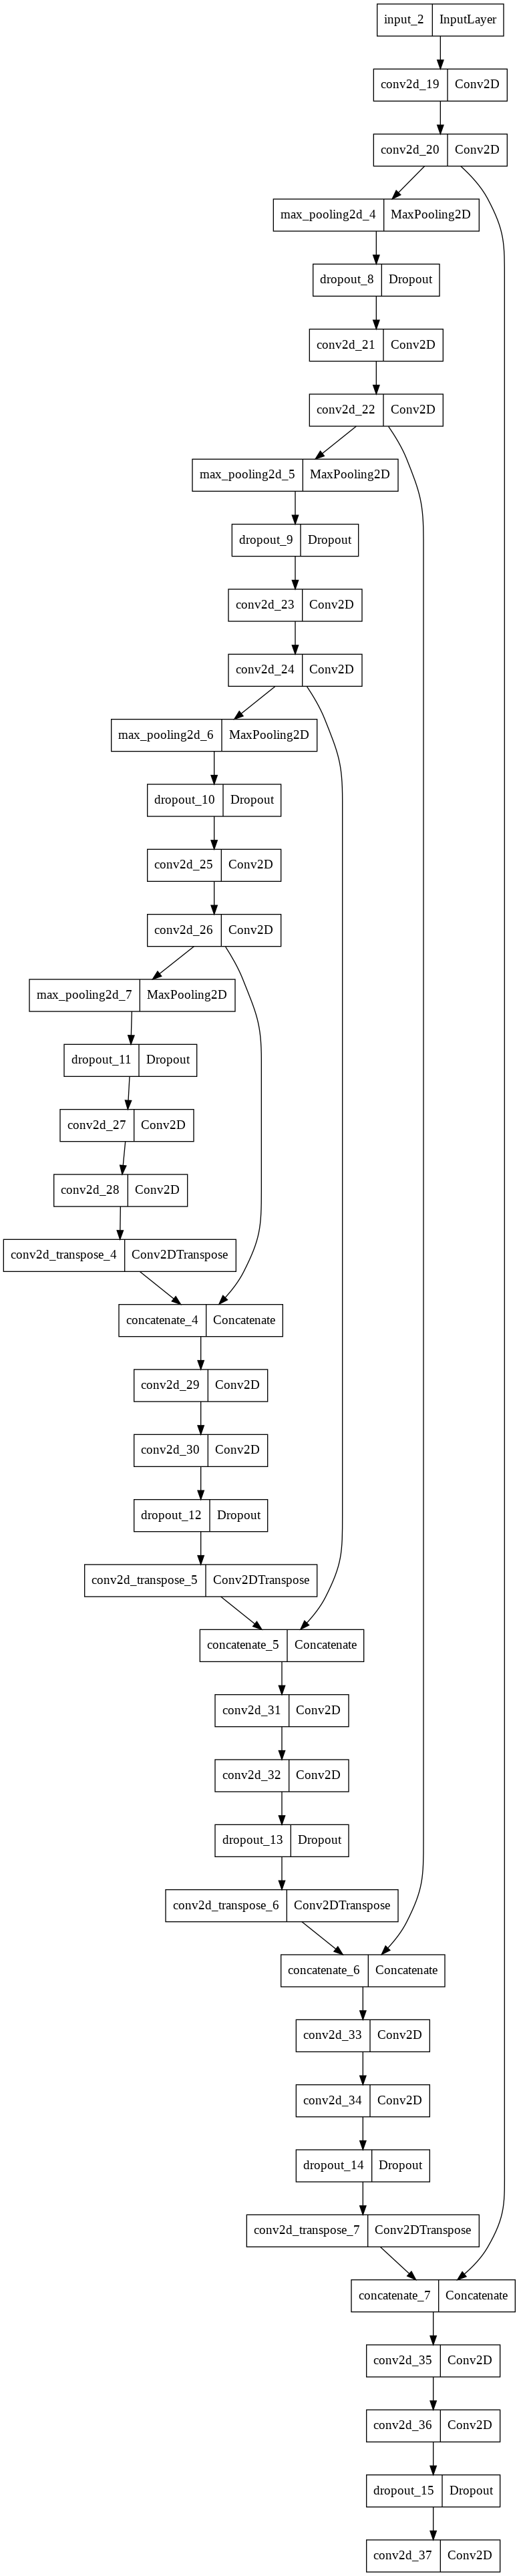

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
#keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

In [ ]:
import tensorflow as tf
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=[tf.keras.metrics.MeanIoU(num_classes=2),'accuracy'])
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_19[0][0]']              
                                )                                                             

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
checkp = ModelCheckpoint('/content/drive/MyDrive/results/unet.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)

In [ ]:
#history = model.fit(X_train, y_train, epochs = 200, batch_size = 64, validation_data = (X_test, y_test), callbacks = [checkp])

Text(0.5, 1.0, 'Losses vs Epochs')

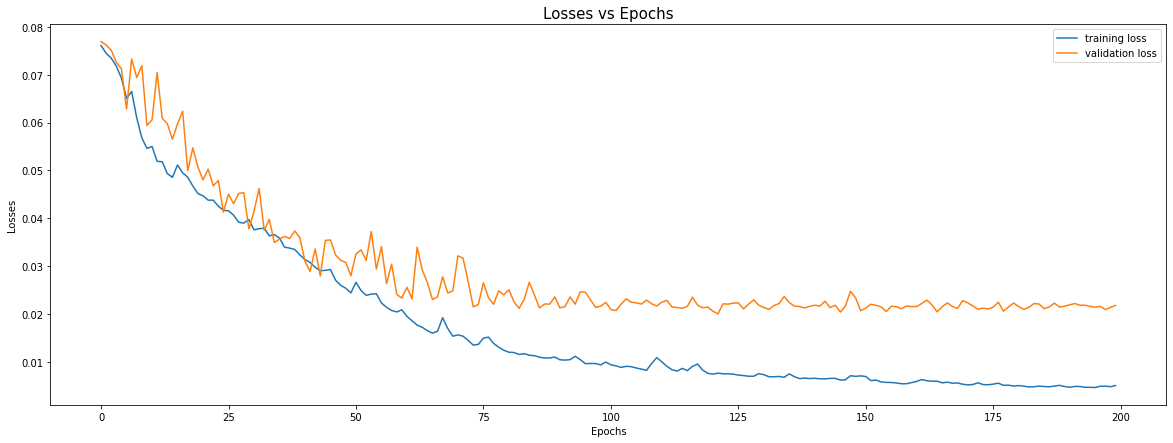

In [ ]:
# plotting the loss vs epochs
plt.figure(figsize = (20,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses vs Epochs', fontsize = 15)

Text(0.5, 1.0, 'Accuracy vs Epochs')

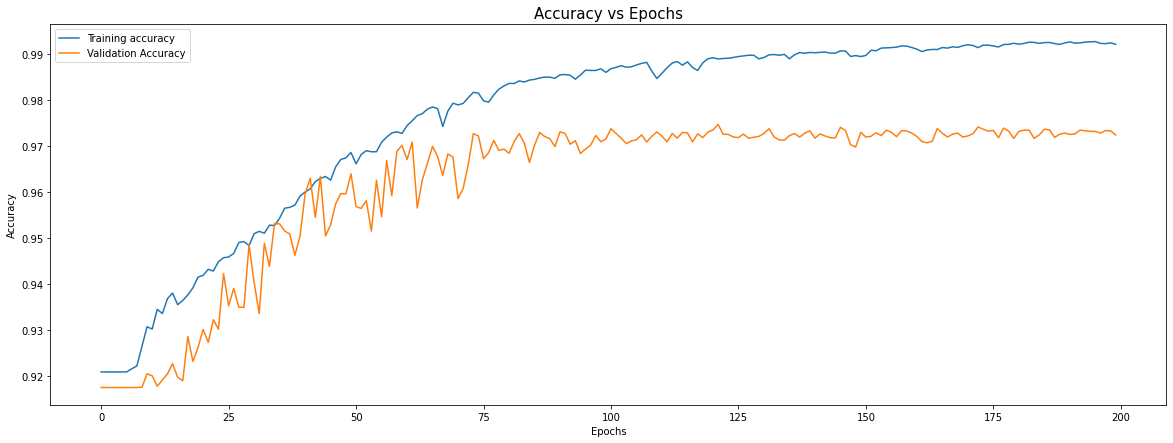

In [ ]:
# plotting the accuracy vs epochs
plt.figure(figsize = (20,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs', fontsize = 15)

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/results/unet.h5')
y_pred = model.predict(X_test)
print(y_pred.shape)

(39, 128, 128, 1)


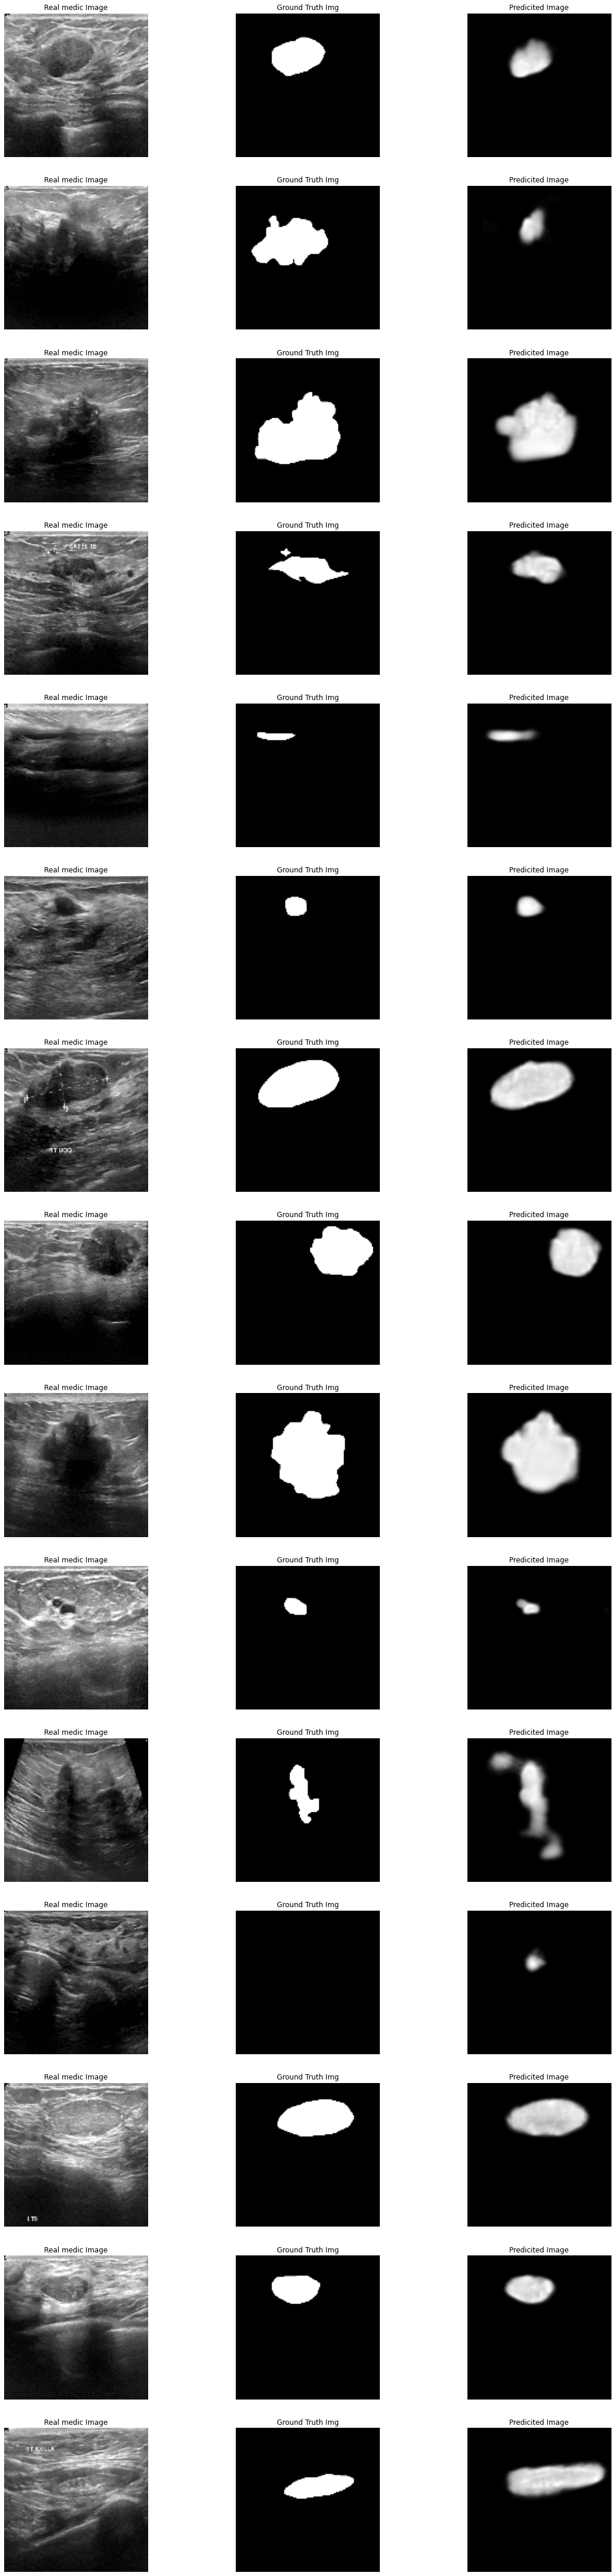

In [ ]:
plt.figure(figsize = (20,80))

i = 0
x = 0
while i < 45 :
    
    plt.subplot(15,3,i+1)
    plt.imshow(X_test[x].reshape(128,128), 'gray')
    plt.title('Real medic Image')
    plt.axis('off')
    
    plt.subplot(15,3,i+2)
    plt.imshow(y_test[x].reshape(128,128), 'gray')
    plt.title('Ground Truth Img')
    plt.axis('off')
    
    plt.subplot(15,3,i+3)
    plt.imshow(y_pred[x].reshape(128,128), 'gray')
    plt.title('Predicited Image')
    plt.axis('off')
    
    x += 1
    i += 3
plt.show()

In [ ]:
##=======================================================THE END=====================================================##